## Programming Exercise 3: Multi-class Classification and Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from PIL import Image

### 1 Multi-class Classification

#### 1.1 Dataset

In [2]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

#### 1.2 Visualizing the data

In [4]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
#     img = scipy.misc.toimage( big_picture )
#     img = 
    plt.imshow(big_picture,cmap = cm.Greys_r)

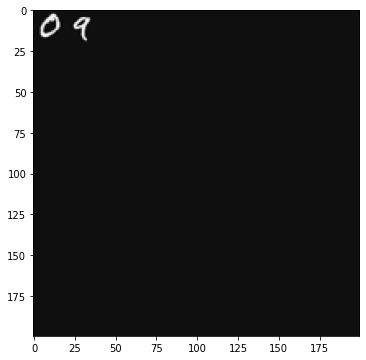

In [5]:
displayData([0,4500])
# dir(scipy.misc)

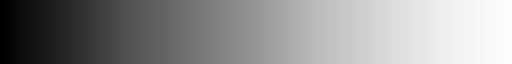

In [6]:
cm.Greys_r

In [7]:
?plt.imshow

#### 1.3 Vectorizing Logistic Regression

In [8]:
#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#A more simply written cost function than last week, inspired by subokita:
def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

#### 1.4 One-vs-all Classification

In [9]:
#An alternative to OCTAVE's 'fmincg' we'll use some scipy.optimize function, "fmin_cg"
#This is more efficient with large number of parameters.
#In the previous homework, I didn't have to compute the cost gradient because
#the scipy.optimize function did it for me with some kind of interpolation...
#However, fmin_cg needs the gradient handed do it, so I'll implement that here
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    #Tranpose y here because it makes the units work out in dot products later
    #(with the way I've written them, anyway)
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    #regularization skips the first element in theta
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    #regularization skips the first element in theta
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

In [10]:
from scipy import optimize
xrange = range
def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [11]:
#Note: I spent a LONG time trying to optimize everything. Initially training 10 classes
#took about 5 minutes. Now I've got it down to taking ~5 seconds total!
def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in xrange(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
    print("Done!")
    return Theta

In [12]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [13]:
Theta.shape

(10, 401)

In [51]:
([10] + list(range(1,10)))[[10]]

TypeError: list indices must be integers or slices, not list

In [74]:
def predictOneVsAll(myTheta,myrow):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + list(range(1,10))
    hypots  = [0]*len(classes)
    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in xrange(len(classes)):
        hypots[i] = h(myTheta[i],myrow)
    print(h(myTheta[i],myrow))
    return classes[np.argmax(np.array(hypots))]    

In [75]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

0.002432688112819552
2.96416468472943e-05
0.0005244797792012632
7.029559124049308e-05
4.950364972714443e-07
5.680052988186598e-06
1.2457071881978422e-05
5.15134095756033e-10
0.00014007602725990743
0.0026230031794025723
0.00017098272998092084
0.00020196664027681167
7.558300617001603e-05
8.788568617549828e-10
3.410364652119717e-07
1.4806245512928193e-05
1.884278631227917e-09
3.4872582885823454e-17
2.6875747389073342e-05
8.211462966251227e-05
0.00014946484609207634
2.5028295851155353e-05
1.884846039362559e-08
0.0007113997727379006
0.010962627712467024
2.7644248175056218e-09
2.862025531914293e-05
1.1511196305462328e-07
7.562352151900254e-12
2.9169522905540533e-07
1.591384922596695e-07
9.098853314821773e-11
5.6025381997394396e-09
0.00042451489068147407
4.013059234258741e-06
0.00022756832587189925
0.001010554967576832
2.657046569978543e-05
8.528143841365216e-10
1.08591455392784e-06
2.0757372817262987e-10
1.7939589204183494e-08
3.624904431073743e-12
0.008616106421981011
5.861702945376744e-09


In [77]:
irow = 1
# predictOneVsAll(Theta,X[irow])
classes = [10] + list(range(1,10))
hypots  = [0]*len(classes)
#Compute a hypothesis for each possible outcome
#Choose the maximum hypothesis to find result
for i in xrange(len(classes)):
    hypots[i] = h(Theta[i],X[irow])
np.argmax(np.array(hypots))
# classes[np.argmax(np.array(hypots))] 

0

In [78]:
hypots

[0.9999987714852692,
 1.2336176593848714e-16,
 1.012779800967742e-05,
 3.137304095205993e-05,
 2.7146769415205693e-09,
 0.0031510719851310202,
 7.279147123732402e-17,
 6.417190737423182e-08,
 3.02942907820162e-07,
 2.96416468472943e-05]

In [71]:
i=0
h(Theta[i],irow).shape

(401,)

In [55]:
(np.array(hypots)).shape

(10, 401)

In [52]:
np.argmax(np.array(hypots))

0

In [29]:
np.array(hypots).shape

(10, 401)

In [36]:
?np.argmax

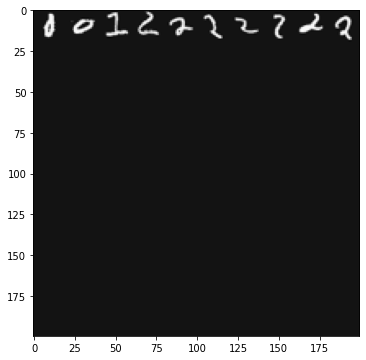

In [46]:
displayData(incorrect_indices[:10])

In [49]:
0 in y

False

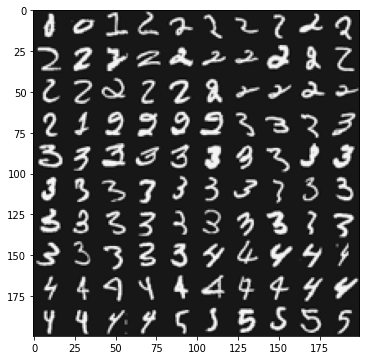

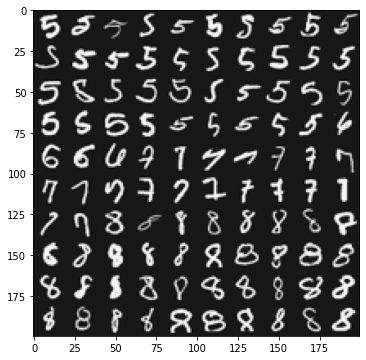

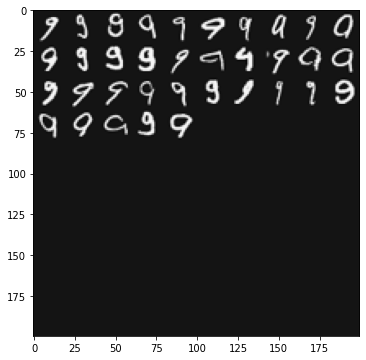

In [17]:
#Let's have a look at the ones we get wrong:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

### 2 Neural Networks

#### 2.1 Model representation

In [79]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex3weights.mat
datafile = 'data/ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print("Theta1 has shape:",Theta1.shape)
print( "Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


#### 2.2 Feedforward Propagation

In [91]:
def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas, propagates the
    Row of features forwards, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in xrange(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) #Add the bias unit
        features = a

def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = list(range(1,10)) + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [92]:
irow = 0
row = X[irow]
features = row

In [94]:
row.shape

(401,)

In [90]:
# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
#Loop over all of the rows in X (all of the handwritten images)
#and predict what digit is written. Check if it's correct, and
#compute an efficiency.
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

[1.12661530e-04 1.74127856e-03 2.52696959e-03 1.84032321e-05
 9.36263860e-03 3.99270267e-03 5.51517524e-03 4.01468105e-04
 6.48072305e-03 9.95734012e-01]
[4.79026796e-04 2.41495958e-03 3.44755685e-03 4.05616281e-05
 6.53412433e-03 1.75930169e-03 1.15788527e-02 2.39107046e-03
 1.97025086e-03 9.95696931e-01]
[8.85702310e-05 3.24266731e-03 2.55419797e-02 2.13621788e-05
 3.96912754e-03 1.02881088e-02 3.86839058e-04 6.22892325e-02
 5.49803551e-03 9.28008397e-01]
[5.57359434e-05 8.04931959e-03 1.78298052e-02 8.65139000e-05
 6.42303668e-04 1.14649511e-02 1.85179778e-03 4.69294678e-03
 8.21314752e-04 9.94104074e-01]
[1.05782491e-04 1.51486552e-03 3.80590161e-03 9.17080890e-05
 2.26294967e-02 8.81080949e-04 4.73565655e-03 1.43648557e-03
 2.09567944e-03 9.92762161e-01]
[5.99295164e-05 2.93535715e-03 3.91263727e-03 2.55435542e-05
 3.50983997e-03 3.91723180e-03 5.44509794e-03 1.34771530e-03
 4.07571773e-03 9.97020598e-01]
[1.57075975e-04 1.85968463e-03 3.21342472e-02 6.76429750e-05
 1.48403912e-03

[9.57111991e-01 1.53300028e-02 6.23927461e-03 1.79563888e-03
 1.83263001e-03 3.29383461e-03 1.80582635e-02 7.98954854e-03
 3.66199016e-03 1.82013875e-05]
[9.74994533e-01 2.21202696e-02 7.12049724e-03 5.01252947e-04
 3.09141123e-04 5.34293458e-03 2.05500731e-03 1.11027482e-02
 5.20798241e-04 3.46943824e-04]
[9.74261729e-01 5.55910551e-03 7.43274142e-03 9.06048975e-04
 2.94769254e-03 3.80160491e-03 1.59011160e-02 2.27151625e-03
 1.88310788e-02 4.13283673e-06]
[9.82784550e-01 1.74547766e-02 3.46887665e-03 3.12707245e-04
 1.11716052e-03 1.33260105e-02 9.73305919e-04 1.44291216e-02
 7.01331801e-04 2.37143951e-04]
[9.00070700e-01 3.91352579e-03 4.01691050e-03 2.05040818e-04
 3.50330943e-02 1.52743610e-02 1.53924268e-03 7.79000926e-03
 5.03061670e-03 1.11324470e-04]
[9.82061940e-01 1.01548954e-02 2.13575953e-02 8.71420173e-04
 5.48579130e-03 9.12423693e-03 1.19616067e-03 5.46321337e-03
 3.97312080e-03 4.82750907e-06]
[9.68032588e-01 7.30159171e-03 7.08359024e-03 4.85932940e-04
 8.18117265e-03

[7.88538552e-02 1.03005929e-02 2.17985880e-01 2.90045716e-03
 1.75035886e-04 1.25478730e-03 2.28920387e-02 5.95105534e-03
 1.68177656e-03 8.42700979e-05]
[2.37582328e-03 2.43066375e-02 9.95982970e-01 4.98803121e-05
 8.68280296e-04 8.66238103e-05 1.65861302e-04 5.79038033e-03
 7.83734846e-04 2.70009082e-04]
[3.30016275e-04 1.45219903e-04 9.97141944e-01 1.06927082e-03
 1.52380112e-03 1.73507855e-06 9.80003353e-04 1.90729780e-02
 6.38293519e-03 1.20599556e-03]
[6.92777361e-05 4.45896992e-03 9.25436347e-01 1.96937284e-03
 8.05933182e-02 5.13609410e-06 4.82255982e-04 5.46020752e-02
 2.14838613e-04 1.93325685e-03]
[5.69880888e-04 3.58104839e-03 9.81602288e-01 9.51537235e-04
 8.29192459e-03 2.69308917e-05 6.31844012e-04 2.35278242e-02
 4.31768874e-04 6.67302821e-04]
[2.36989730e-03 1.31390353e-03 9.84175006e-01 6.12715630e-04
 3.17818837e-03 8.25595049e-06 1.82408684e-03 4.46165570e-02
 3.21345171e-03 4.83516891e-04]
[6.17764739e-04 1.74275739e-04 9.87750890e-01 5.68353221e-04
 8.97881376e-03

[8.53353888e-05 4.15171263e-06 4.67139489e-02 1.02342765e-03
 9.84112809e-01 1.20663289e-04 9.31049396e-05 1.80757830e-02
 7.63789572e-03 6.28413970e-03]
[6.25981124e-02 5.27469753e-04 2.98028219e-03 2.19913392e-02
 8.35234320e-01 3.25666429e-03 4.02111863e-03 1.02888058e-01
 3.29006419e-04 5.45540475e-03]
[3.18902665e-04 8.33648635e-06 2.16319523e-02 1.32390231e-02
 9.33882918e-01 9.67238077e-04 9.60730388e-05 2.50819319e-02
 8.39994881e-02 1.10066591e-03]
[7.61225092e-03 1.96060034e-03 3.04525746e-02 1.64507025e-04
 7.01066934e-01 9.36150917e-02 1.34009059e-05 1.02783705e-03
 4.24711455e-03 8.07631508e-03]
[7.10736526e-04 3.60214622e-04 6.25556576e-04 8.72857143e-04
 8.54956542e-01 2.75425028e-01 4.02590142e-05 7.65455541e-04
 1.55393555e-03 2.84434711e-02]
[8.85895286e-04 4.88432715e-05 6.00540977e-03 4.58894368e-04
 9.87621077e-01 2.66742222e-02 1.96575825e-05 5.91306803e-03
 3.76804133e-03 1.15664971e-02]
[2.92608996e-04 1.92799279e-06 5.40319614e-02 2.11375888e-03
 9.71943271e-01

[5.17026720e-04 2.26853597e-03 1.58588510e-03 4.60023526e-04
 1.66493232e-04 1.36934360e-05 9.94578834e-01 2.98153777e-04
 6.06632233e-03 6.00877797e-04]
[1.35913312e-03 2.74814401e-04 3.90746897e-04 4.61204991e-03
 1.24657632e-03 1.27354381e-05 9.71030879e-01 1.17152919e-04
 1.58216435e-02 7.90124810e-04]
[4.58098433e-03 1.21716396e-02 3.95674353e-04 4.13713575e-03
 8.47671988e-04 5.43866633e-04 8.03507324e-01 6.29036086e-03
 1.24712833e-01 3.05154901e-05]
[1.82685917e-03 1.07682748e-02 9.38503049e-03 2.47048835e-04
 4.28938404e-04 3.15710014e-06 9.97506435e-01 3.26328731e-04
 4.66942004e-03 3.41739546e-04]
[5.72433974e-04 5.33133707e-06 3.13575079e-03 1.41004078e-02
 5.49957014e-03 1.58654123e-03 9.80228690e-01 3.88970831e-03
 8.52104081e-02 1.56994261e-02]
[4.63384559e-04 7.17716132e-04 3.73580903e-03 9.92439844e-04
 9.94171575e-04 1.84715177e-05 9.98211861e-01 6.65218840e-05
 1.33998614e-03 1.18852223e-03]
[7.91906691e-04 5.58335098e-04 2.13531125e-03 1.76191150e-03
 4.58270998e-04

[4.57194914e-04 1.19755469e-03 1.10171141e-04 2.17336777e-02
 6.50385602e-04 5.70679034e-04 1.87265546e-01 2.25197324e-03
 9.13001508e-01 1.14992875e-03]
[2.26993289e-03 1.04357528e-03 6.87995441e-04 2.10461824e-02
 7.12394989e-04 4.21417265e-04 3.42128841e-02 3.41071477e-03
 9.51478326e-01 6.79835004e-05]
[1.09941733e-04 1.96062031e-02 1.86089608e-05 8.46126058e-03
 1.69905297e-04 9.62935788e-04 4.15965063e-02 2.11700673e-02
 9.21315006e-01 1.56184891e-03]
[7.17776257e-05 1.76690045e-04 3.54683938e-02 1.38593077e-03
 1.86005170e-03 6.54906616e-05 6.49417205e-02 2.62312570e-03
 8.97443927e-01 3.03846045e-04]
[1.10935677e-02 4.54238848e-03 5.88169388e-03 2.23456937e-02
 5.28951244e-04 4.26884732e-04 4.04172425e-03 1.45008136e-02
 9.55266794e-01 8.30956727e-04]
[2.43561626e-03 7.11121192e-03 5.87917510e-02 6.54865183e-02
 2.93020403e-04 1.78965599e-04 5.96651071e-03 1.29369361e-03
 9.71485414e-01 1.32875466e-05]
[2.16339243e-04 6.90355711e-04 2.21183373e-04 1.57899985e-02
 6.21429152e-04

In [82]:
#Pick some of the images we got WRONG and look at them, just to see
for x in xrange(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')

AttributeError: module 'scipy.misc' has no attribute 'toimage'

<Figure size 216x216 with 0 Axes>